**In this project we predicted daily gold prices (GLD) using market indicators and engineered time-series features (lags, rolling means, returns, and silver/gold ratio). We compared Linear Regression, Random Forest, and XGBoost. XGBoost gave the best performance with RMSE =  0.1024 and R² Score: 0.9996 on the test set. Feature importance analysis shows that [top features] are the strongest predictors. Next steps: tune hyperparameters with time-series CV, experiment with deep-learning models (LSTM) for sequence learning, and incorporate macro indicators (inflation, interest rates) for longer-term forecasting.**

In [244]:
#Import Libraries
#These libraries provide data handling, visualization, machine learning models, and evaluation tools required for forecasting.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [246]:
# Load Dataset
# Loading the dataset from CSV. This is the raw financial data containing Date, Gold (GLD), Silver (SLV), SPX, Oil (USO), and EUR/USD exchange rate.
data = pd.read_csv("https://raw.githubusercontent.com/akkilkg/Gold-Price-Prediction/refs/heads/main/gld_price_data.csv")

In [248]:
data.head()

,Date,SPX,GLD,USO,SLV,EUR/USD
0,1/2/2008,1447.160034,84.860001,78.470001,15.180,1.471692
1,1/3/2008,1447.160034,85.570000,78.370003,15.285,1.474491
2,1/4/2008,1411.630005,85.129997,77.309998,15.167,1.475492
3,1/7/2008,1416.180054,84.769997,75.500000,15.053,1.468299
4,1/8/2008,1390.189941,86.779999,76.059998,15.590,1.557099


In [250]:
print(type(data))  
print(data.head()) 
print(data.columns)  

<class 'pandas.core.frame.DataFrame'>
       Date          SPX        GLD        USO     SLV   EUR/USD
0  1/2/2008  1447.160034  84.860001  78.470001  15.180  1.471692
1  1/3/2008  1447.160034  85.570000  78.370003  15.285  1.474491
2  1/4/2008  1411.630005  85.129997  77.309998  15.167  1.475492
3  1/7/2008  1416.180054  84.769997  75.500000  15.053  1.468299
4  1/8/2008  1390.189941  86.779999  76.059998  15.590  1.557099
Index(['Date', 'SPX', 'GLD', 'USO', 'SLV', 'EUR/USD'], dtype='object')


In [252]:
data.describe()

,SPX,GLD,USO,SLV,EUR/USD
count,2290.000000,2290.000000,2290.000000,2290.000000,2290.000000
mean,1654.315776,122.732875,31.842221,20.084997,1.283653
std,519.111540,23.283346,19.523517,7.092566,0.131547
min,676.530029,70.000000,7.960000,8.850000,1.039047
25%,1239.874969,109.725000,14.380000,15.570000,1.171313
50%,1551.434998,120.580002,33.869999,17.268500,1.303297
75%,2073.010070,132.840004,37.827501,22.882500,1.369971
max,2872.870117,184.589996,117.480003,47.259998,1.598798


In [254]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2290 non-null   object 
 1   SPX      2290 non-null   float64
 2   GLD      2290 non-null   float64
 3   USO      2290 non-null   float64
 4   SLV      2290 non-null   float64
 5   EUR/USD  2290 non-null   float64
dtypes: float64(5), object(1)
memory usage: 107.5+ KB


In [256]:
data.set_index('Date',inplace = True)

In [258]:
# Convert Date Column and numeric columns
# Converting 'Date' into datetime format and setting it as index enables time-series processing andcolumns to numeric ensures models receive proper numeric input. Non-numeric values become NaN and are later removed.
data['Date'] = pd.to_datetime(data['Date'])
data.index = pd.to_datetime(data.index)
cols = ['SPX','GLD','USO','SLV','EUR/USD']
df[cols] = df[cols].apply(pd.to_numeric, errors = "coerce")
df.dtypes

SPX        float64
GLD        float64
USO        float64
SLV        float64
EUR/USD    float64
dtype: object

In [262]:
# Check Missing Values
# Financial data can contain missing values. Identifying them early helps prevent model errors later.
data.isna().sum()

SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

In [264]:
data.duplicated().sum()

0

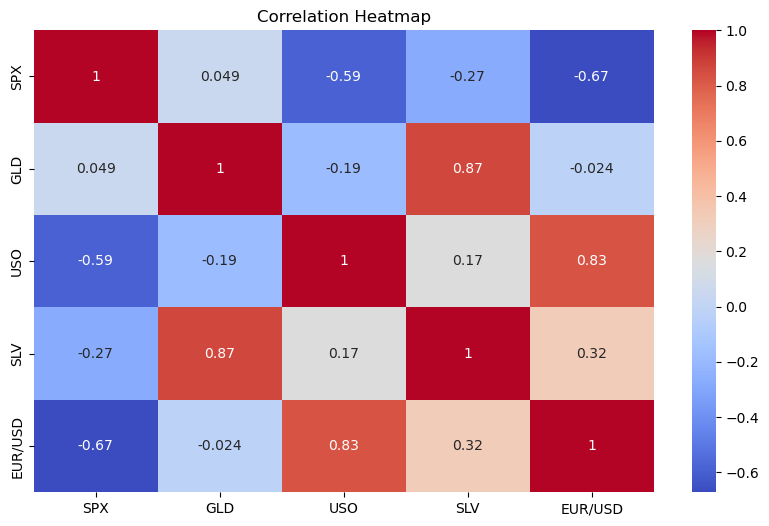

In [266]:
# 8. Correlation Heatmap
# Correlation helps identify useful predictors and relationships between variables.
corr = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

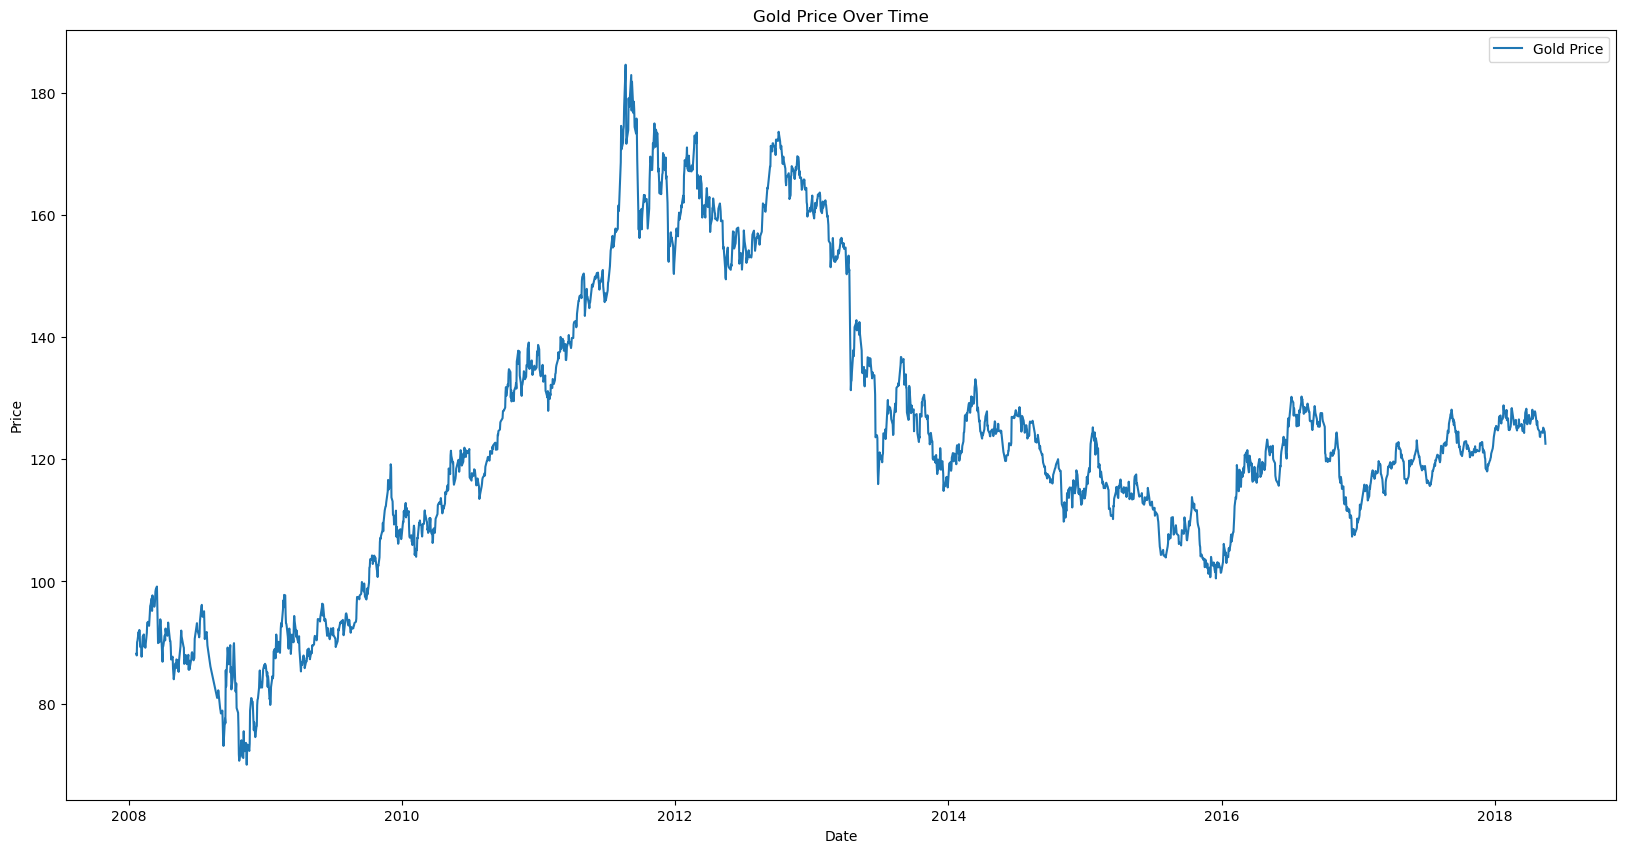

In [364]:
# 9. Visualize Gold Price Over Time
# Visualizing GLD trend helps spot long-term movements, volatility, and seasonality.
plt.figure(figsize=(20,10))
plt.plot(df.index,df['GLD'],label='Gold Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Gold Price Over Time')
plt.legend()
plt.show()

In [268]:
df = data.copy()

In [270]:
df['GLD_lag1'] = df['GLD'].shift(1)
df['GLD_lag3'] = df['GLD'].shift(3)
df['GLD_lag7'] = df['GLD'].shift(7)

In [272]:
df['GLD_roll3'] = df['GLD'].rolling(window=3).mean()
df['GLD_roll7'] = df['GLD'].rolling(window=7).mean()
df['GLD_roll14'] = df['GLD'].rolling(window=14).mean()

In [274]:
df['GLD_return'] = df['GLD'].pct_change()

In [276]:
df['SLV_to_GLD'] = df['SLV'] / df['GLD']

In [368]:
df.dropna(inplace=True)

In [282]:
# 11. Create X and y
# X contains predictor variables. y contains the target (GLD). This separation is essential for model training.
X = df.drop(["GLD"], axis = 1)
y = df["GLD"]

In [284]:
# 12. Train-Test Split
# Training on 80% of data and testing on 20% ensures fair model evaluation.
train_size = int(0.8 * len(df))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (1821, 12) Test: (456, 12)


In [286]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [302]:
# Train Model
# RandomForestRegressor is chosen due to its strong ability to capture nonlinear relationships.
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [304]:
# Make Predictions
# Using the trained model to predict Gold prices on the test set.
y_pred_lr = lr.predict(X_test_scaled)
y_pred_lr

array([119.36744687, 118.89192365, 119.51935431, 118.18091039,
       118.75220717, 118.89535698, 121.17563383, 122.97770633,
       122.93494939, 122.33037393, 122.05007609, 120.64710061,
       121.00316005, 121.9220226 , 121.12940536, 121.85454589,
       122.05648116, 120.19096304, 119.99302563, 119.24578854,
       117.37431971, 117.06780489, 116.47470273, 116.0693045 ,
       115.94140951, 115.64151028, 118.87339461, 118.58288556,
       120.67979206, 121.0605436 , 122.57632876, 122.65820508,
       123.63715207, 122.36780883, 123.24534897, 120.82519818,
       121.056258  , 119.9800711 , 126.39240072, 124.9286634 ,
       126.2001825 , 126.23824879, 129.13047538, 129.92406639,
       129.83391903, 129.34168572, 127.30090751, 128.26205306,
       127.17463857, 127.14740372, 127.10475795, 125.47358439,
       127.21926321, 125.35184747, 126.12604974, 127.66458998,
       127.53792245, 129.15131695, 129.97166515, 129.6705202 ,
       129.86982692, 127.57541469, 128.01464091, 128.27

In [336]:
# Evaluation
# RMSE shows prediction error in price units. R² shows proportion of variance explained.
from sklearn.metrics import root_mean_squared_error, r2_score
rmse_lr = root_mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"RMSE: {rmse_lr:.4f}")
print(f"R² Score: {r2_lr:.4f}")

RMSE: 0.1024
R² Score: 0.9996


In [338]:
from sklearn.ensemble import RandomForestRegressor
rf= RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [340]:
y_pred_rf = rf.predict(X_test)
y_pred_rf

array([118.85134984, 118.5157501 , 119.42734966, 118.46749954,
       118.62564936, 118.58194943, 120.97215034, 122.21094914,
       122.31984961, 121.91584979, 122.11074969, 120.91070101,
       121.3161003 , 121.79195011, 121.04405118, 121.90505052,
       121.87785058, 120.47660059, 120.14170055, 119.53799984,
       117.61735092, 117.44724986, 116.58570028, 116.21810028,
       116.04960034, 115.80255035, 118.11545052, 118.03030043,
       120.42730102, 120.94224999, 122.27644958, 122.34104928,
       123.36059859, 121.86905002, 123.43669912, 121.11345093,
       121.47480089, 120.00205083, 123.68669789, 123.82049909,
       125.72285021, 125.71229983, 128.1227984 , 129.00800064,
       128.58464957, 128.76574995, 127.69924882, 128.54654805,
       127.30454978, 127.11449916, 126.83644992, 125.51744954,
       126.62319966, 125.29284929, 125.5850499 , 127.05389968,
       127.20884964, 128.80604894, 129.17960017, 128.68414948,
       129.13935082, 127.02449869, 127.92049837, 128.20

In [342]:
from sklearn.metrics import root_mean_squared_error, r2_score
rmse_rf = root_mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f"RMSE: {rmse_rf:.4f}")
print(f"R² Score: {r2_rf:.4f}")

RMSE: 0.4419
R² Score: 0.9917


In [344]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1)

xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [346]:
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb


array([119.307396, 119.000946, 119.750824, 118.30756 , 118.654526,
       118.71672 , 121.32743 , 122.57497 , 122.48099 , 121.92522 ,
       122.62725 , 120.75906 , 121.05197 , 121.85393 , 121.05011 ,
       121.96653 , 122.01782 , 120.10967 , 120.244   , 119.4899  ,
       117.4087  , 117.37683 , 116.367905, 115.96448 , 116.14872 ,
       115.62276 , 118.62287 , 118.12904 , 120.59979 , 121.233345,
       122.38823 , 122.29296 , 123.319145, 121.51784 , 123.052444,
       120.60784 , 121.42031 , 119.96257 , 124.16919 , 124.29495 ,
       125.955315, 125.832436, 128.65549 , 129.3282  , 128.65105 ,
       129.23712 , 127.280495, 129.00896 , 127.16708 , 127.44817 ,
       127.06761 , 125.258865, 127.08421 , 125.113235, 125.83493 ,
       127.564545, 127.440315, 129.25737 , 130.0469  , 128.99718 ,
       129.5993  , 126.80908 , 127.63557 , 128.40092 , 127.08157 ,
       127.445816, 127.675026, 127.38666 , 127.79226 , 126.624   ,
       127.26574 , 126.022064, 126.20489 , 125.788216, 124.646

In [352]:
rmse_xgb = np.sqrt(root_mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R² Score: {r2_xgb:.4f}")

RMSE: 0.6008
R² Score: 0.9944


In [360]:
#Comparison table between LinearRegression,RandomForest,XGBoost.
results = pd.DataFrame({
    "Model": ["LinearRegression", "RandomForest", "XGBoost"],
    "RMSE": [rmse_lr, rmse_rf, rmse_xgb],
    "R2": [r2_lr, r2_rf, r2_xgb]
})
display(results.sort_values('RMSE'))


,Model,RMSE,R2
0,LinearRegression,0.102446,0.999553
1,RandomForest,0.441878,0.991681
2,XGBoost,0.600782,0.994449


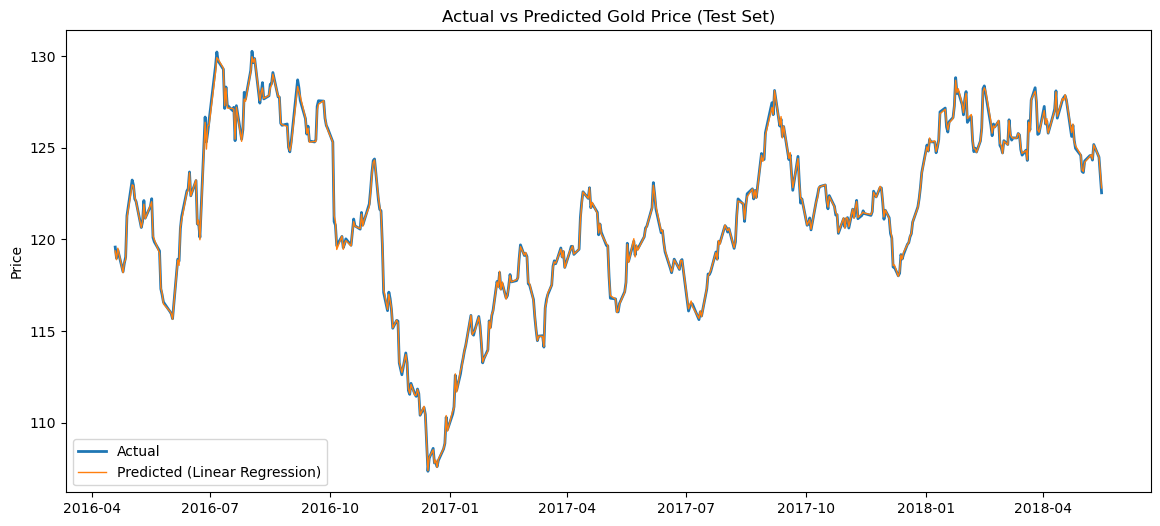

In [358]:
#Pred vs Actual Plot
# This visualization compares actual vs predicted prices, making model performance easy to interpret.
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred_lr, label='Predicted (Linear Regression)', linewidth=1)
plt.legend()
plt.title("Actual vs Predicted Gold Price (Test Set)")
plt.ylabel("Price")
plt.show()